#### Lecture 9 - Root finding: Open methods

Extend C&C Example 5.3-5.5

Add Newton-Raphson and Secant Methods, compare convergence to bracketing methods from last class.
$$v(t) = \frac{gm}{c}(1 - e^{-ct/m})$$

Given $m = 68.1$ kg, $t = 10$ s, $v(t) = 40$ m/s

- Solve for $c$ using initial guess $x_0=12$
- Plot $log(|f(x)|)$ vs. number of iterations $n$

In [1]:
import numpy as np

m = 68.1
t = 10
v = 40
g = 9.81

def f(c):
    return g*m/c * (1 - np.exp(-c*t/m)) - v  # set f(c) = 0

In [2]:
# functions from last class
def bisection(f, xl, xu, tol=1e-8):
    
    # check for valid initial bracket
    assert f(xl) * f(xu) < 0, 'Choose xl,xu such that f(xl) * f(xu) < 0'
    err = 9999
    errors = [] # store errors to plot later
    
    while err > tol:
        xr = (xl + xu) / 2
        test = f(xl) * f(xr)
        if test < 0:
            xu = xr
        elif test > 0:
            xl = xr
        err = np.abs(f(xr))
        errors.append(err)
    
    return xr, errors

def falseposition(f, xl, xu, tol=1e-8):
    
    # check for valid initial bracket
    assert f(xl) * f(xu) < 0, 'Choose xl,xu such that f(xl) * f(xu) < 0'
    err = 9999
    errors = [] # store errors to plot later
    
    while err > tol:
        xr = xu - f(xu) * (xl - xu) / (f(xl) - f(xu))
        test = f(xl) * f(xr)
        if test < 0:
            xu = xr
        elif test > 0:
            xl = xr
        err = np.abs(f(xr))
        errors.append(err)
    
    return xr, errors

In [3]:
def newtonraphson(f, fp, x, tol=1e-8):

    err = 9999
    errors = [] # store errors to plot later
    
    while err > tol:
        x = x - f(x)/fp(x)
        err = np.abs(f(x))
        errors.append(err)
    
    return x, errors

Newton-Raphson also requires the [derivative function](https://www.wolframalpha.com/input?i2d=true&i=D%5BDivide%5Bgm%2Cc%5D%5C%2840%291-Power%5Be%2C-Divide%5Bc%2Cm%5Dt%5D%5C%2841%29-v%2Cc%5D). 

In [4]:
def fp(c):
    return g * (m - np.exp(c*t/m)*m + c*t) / (c**2 * np.exp(c*t/m))

In [5]:
xr, errors_n = newtonraphson(f, fp, 12)

print('Estimate of root: %0.4f' % xr)
print('Iterations: %d' % len(errors_n))

Estimate of root: 14.8011
Iterations: 4


The Secant method is the same except for the update equation. Instead of sending in two initial guesses, create the second guess $x_1=x_0+\delta$, where $\delta=0.01$.

In [6]:
def secant(f, x0, tol=1e-8):

    err = 9999
    errors = [] # store errors to plot later
    
    x1 = x0 + 0.01
    
    while err > tol:
        temp = x1
        x1 = x1 - f(x1) * (x0 - x1) / (f(x0) - f(x1))
        x0 = temp
        err = np.abs(f(x1))
        errors.append(err)
    
    return x1, errors

In [7]:
xr, errors_s = secant(f, 12)

print('Estimate of root: %0.4f' % xr)
print('Iterations: %d' % len(errors_s))

Estimate of root: 14.8011
Iterations: 5


Check root with scipy (docs [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton.html#scipy.optimize.newton)). One point of interest:
```
fprime  callable, optional
The derivative of the function when available and convenient. If it is None (default), then the secant method is used.
```

In [8]:
import scipy.optimize as sopt
sopt.newton(f, 12)

np.float64(14.801135944991259)

The general choice for root finding problems in Scipy is `fsolve` (Docs [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html)), which uses a more advanced method. The bottom of the docs page shows an example of solving a nonlinear system of equations.

Now we have all four methods implemented. How do they compare?

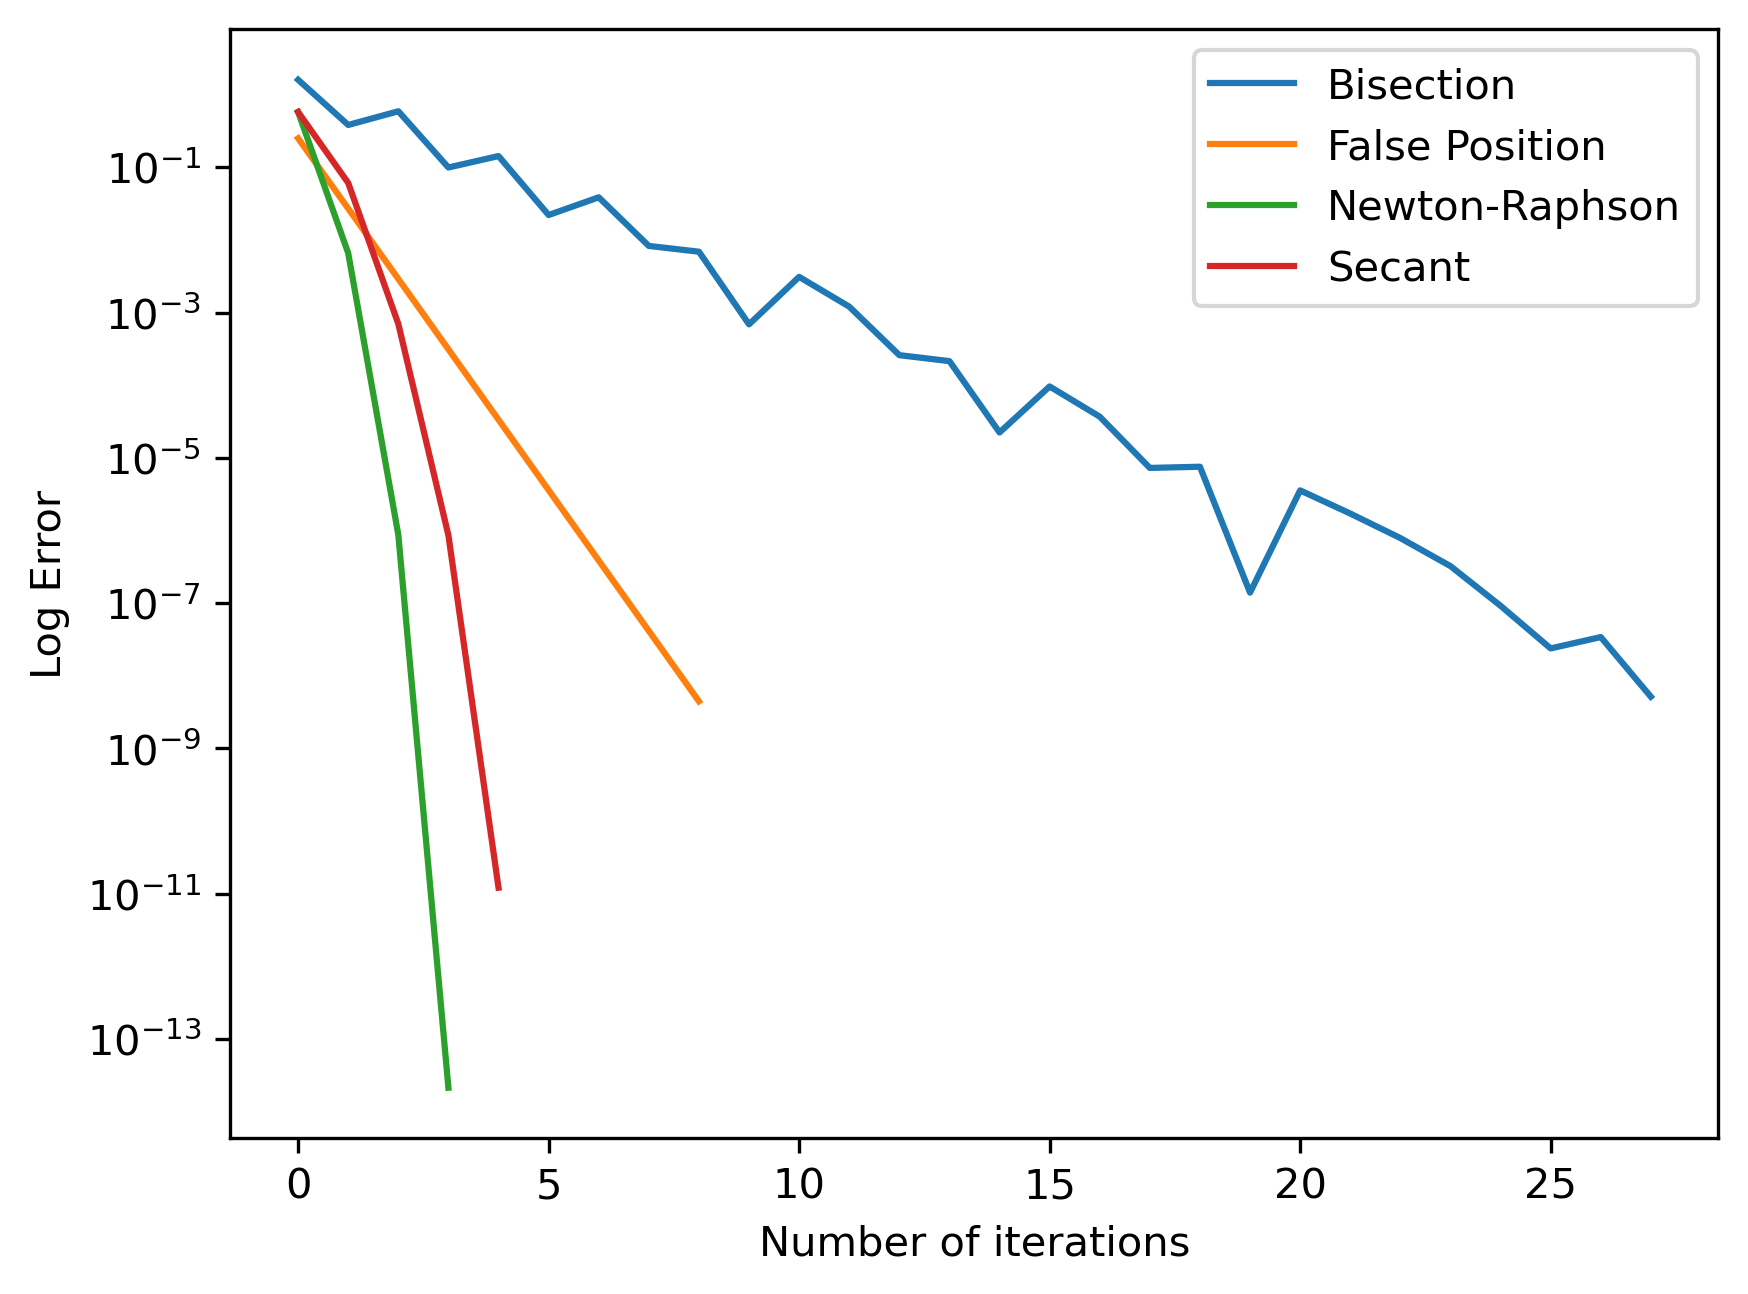

In [9]:
xr, errors_b = bisection(f, 12, 16)
xr, errors_f = falseposition(f, 12, 16)

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.semilogy(errors_b)
plt.semilogy(errors_f)
plt.semilogy(errors_n)
plt.semilogy(errors_s)
plt.ylabel('Log Error')
plt.xlabel('Number of iterations')
plt.legend(['Bisection', 'False Position', 'Newton-Raphson', 'Secant'])
plt.show()

##### Case Study 8.4 C&C
Find friction factor $f$ for turbulent flow from the Colebrook Equation

Solve using Newton-Raphson with initial guess in the range $f \in [0.008, 0.08]$

In [10]:
e  = 0.0015/1000 # pipe roughness, m
D = 0.005 # diameter, m
Re = 13743 # Reynolds number
a = e / (3.7*D) # group constants together to simplify equations
b = 2.51 / Re 

# name function g since unknown is f
def g(f):
    g = 1/np.sqrt(f) + 2*np.log10(a + b/np.sqrt(f))
    return g

def gp(f):
    gp = -1/2 * f**(-3/2) * (1 + (2/np.log(10)*(b/(a + b * f**(-1/2)))))
    return gp

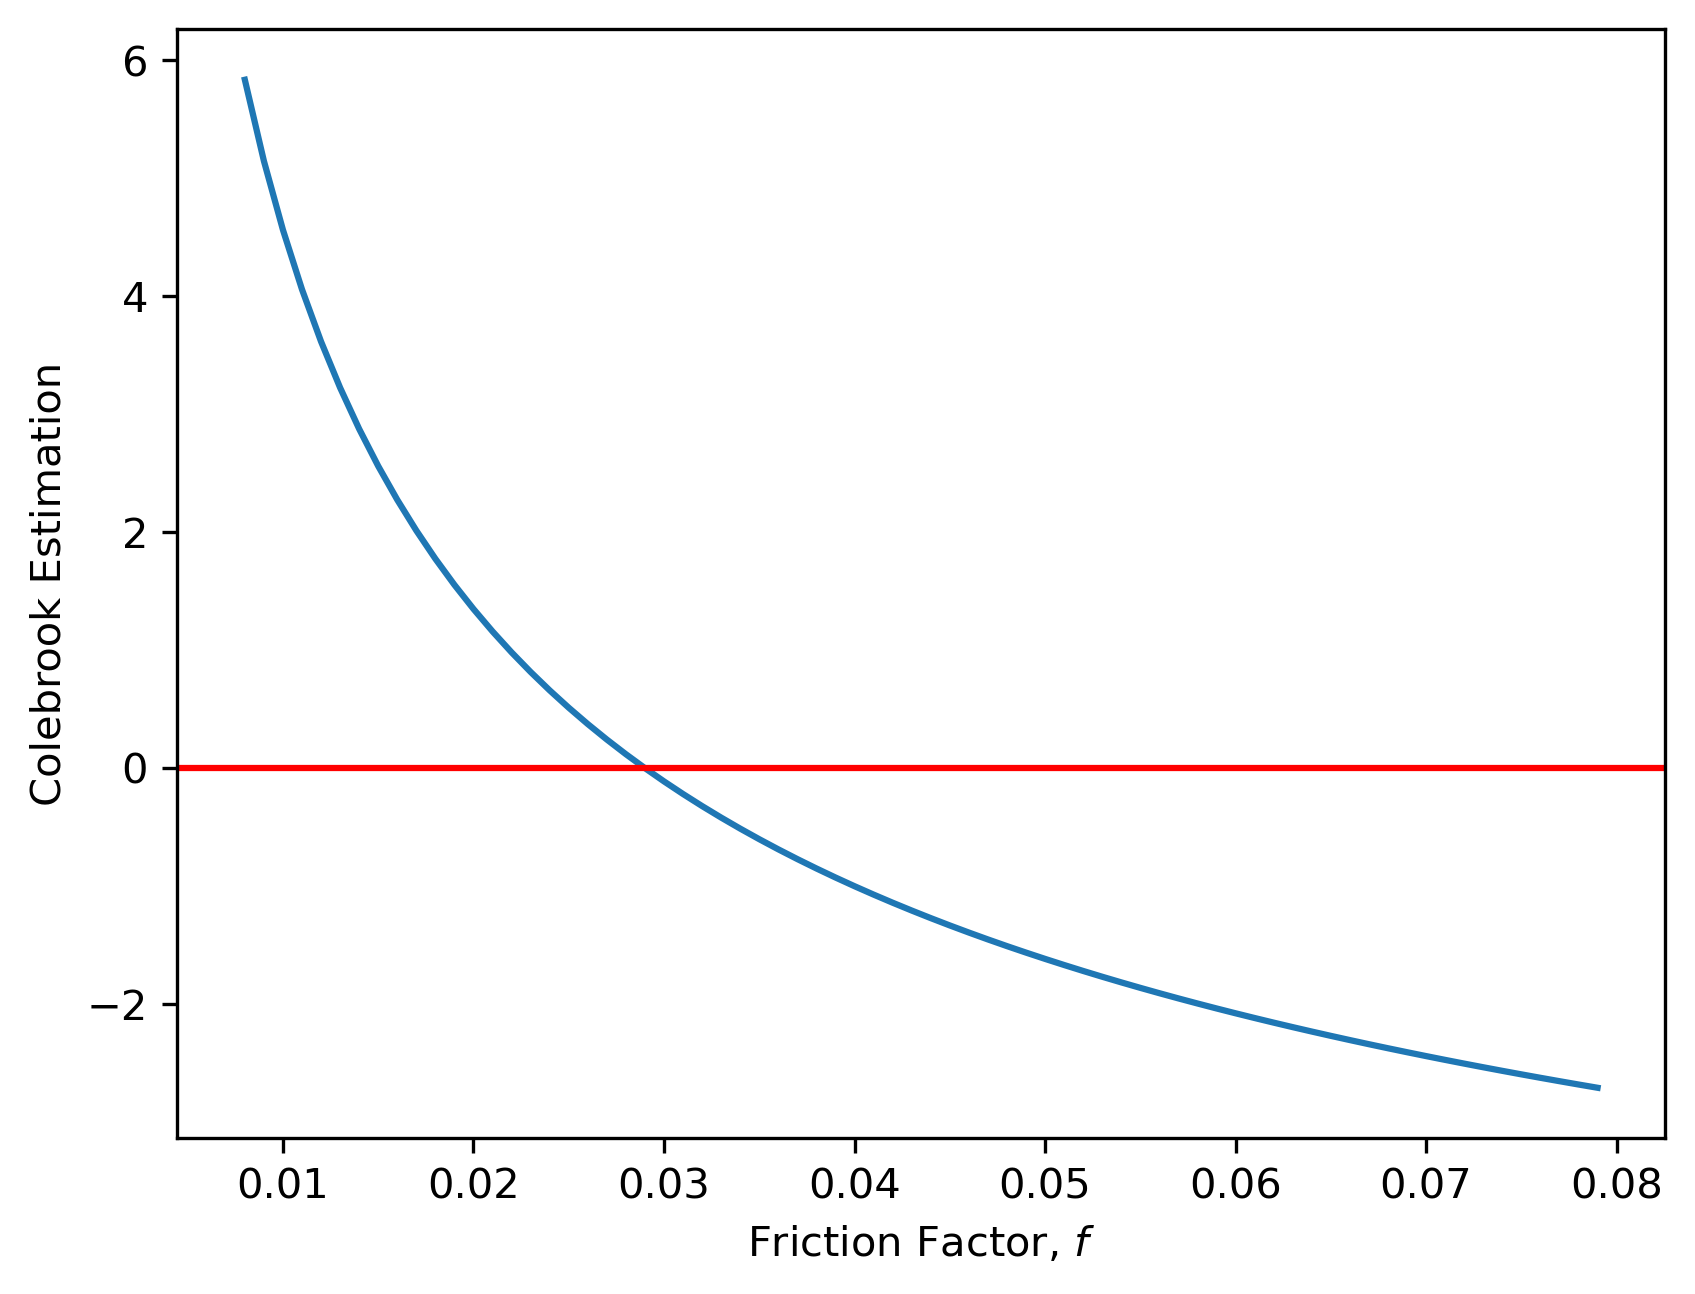

In [11]:
# plot function to choose initial guess
x = np.arange(.008,.08,.001)
plt.plot(x, g(x))
plt.axhline(0, color = 'red')
plt.xlabel('Friction Factor, $f$');plt.ylabel('Colebrook Estimation')
plt.show()

An initial guess $f_0 = 0.01$ should work.

In [12]:
f, errors_n = newtonraphson(g, gp, 0.01)

print('Estimate of root: %0.4f' % f)
print('Iterations: %d' % len(errors_n))

Estimate of root: 0.0290
Iterations: 5


The secant method might be a better choice for this problem because the derivative is difficult.

In [13]:
f, errors_s = secant(g, 0.01)

print('Estimate of root: %0.4f' % f)
print('Iterations: %d' % len(errors_s))

Estimate of root: 0.0290
Iterations: 6


Notice on the graph, if we picked an initial guess near the upper end of the range, the tangent line would put the next guess at a negative value of $f$. The equation is undefined here, so the open methods diverge. In this case they will not run infinitely, instead it throws a warning because the `sqrt` function is undefined for negative inputs. This shows that the speed of open methods comes with the tradeoff of divergence depending on the function and initial guess.

In [14]:
f, errors_n = newtonraphson(g, gp, 0.08)
# stops after one iteration because f is negative
print('Estimate of root: %0.4f' % f)
print('Iterations: %d' % len(errors_n))

Estimate of root: -0.0218
Iterations: 1


/var/folders/3q/q4pw14qn3r95vp8fslqnfl340000gn/T/ipykernel_20018/388212366.py:9: RuntimeWarning: invalid value encountered in sqrt
  g = 1/np.sqrt(f) + 2*np.log10(a + b/np.sqrt(f))
